In [1]:
!pip install pip install feature-engine


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from feature_engine.encoding import RareLabelEncoder

# EDA

In [2]:
data = pd.read_csv('data/get_around_pricing_project.csv', index_col=0)
data.shape

(4843, 14)

In [9]:
data.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [10]:
print("Percentage of missing values: ")
round(100*data.isnull().sum()/data.shape[0] ,2).sort_values(ascending=False)

Percentage of missing values: 


model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

## Target distribution

<AxesSubplot:xlabel='rental_price_per_day', ylabel='Count'>

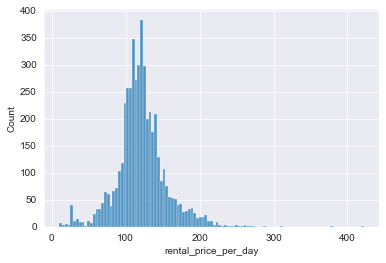

In [11]:
sns.histplot(x=data['rental_price_per_day'])

## Numeric features
### Mileage

In [31]:
data['mileage'].describe()

count    4.843000e+03
mean     1.409628e+05
std      6.019674e+04
min     -6.400000e+01
25%      1.029135e+05
50%      1.410800e+05
75%      1.751955e+05
max      1.000376e+06
Name: mileage, dtype: float64

In [37]:
index_to_drop = data[data['mileage'] <=0].index
data.drop(index_to_drop, axis=0, inplace=True)

<AxesSubplot:xlabel='mileage'>

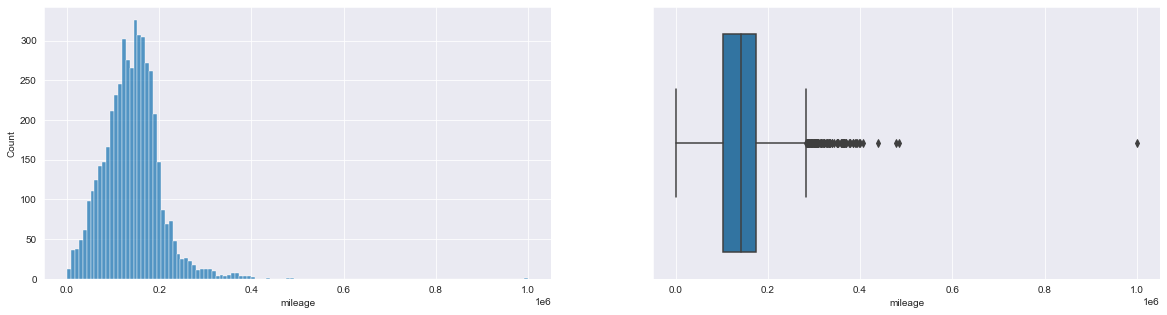

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(x=data['mileage'], ax=axes[0])
sns.boxplot(x=data['mileage'], ax=axes[1])

In [43]:
def find_outliers (df, column):

    # finding the 1st quartile
    q1 = np.quantile(df[column], 0.25)
 
    # finding the 3rd quartile
    q3 = np.quantile(df[column], 0.75)

    # finding the iqr region
    iqr = q3-q1

    # finding upper and lower whiskers
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    
    outliers = df[(df[column] <= lower_bound) | (df[column] >= upper_bound)]
    
    return outliers
    

In [44]:
outliers_mileage = find_outliers(data, 'mileage')
outliers_mileage.shape

(98, 14)

### Engine power

In [46]:
data['engine_power'].describe()

count    4842.000000
mean      128.967369
std        38.970348
min         0.000000
25%       100.000000
50%       120.000000
75%       135.000000
max       423.000000
Name: engine_power, dtype: float64

In [49]:
index_to_drop = data[data['engine_power'] ==0].index
data.drop(index_to_drop, axis=0, inplace=True)

<AxesSubplot:xlabel='engine_power'>

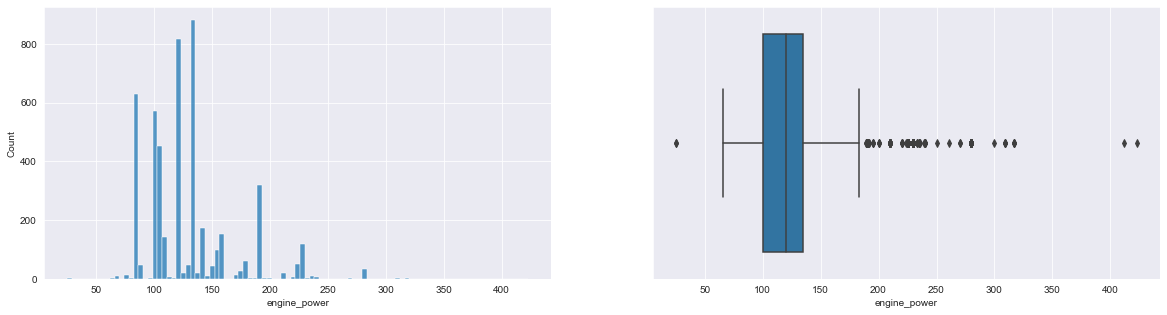

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(x=data['engine_power'], ax=axes[0])
sns.boxplot(x=data['engine_power'], ax=axes[1])

In [52]:
outliers_engine_power = find_outliers(data, 'engine_power')
outliers_engine_power.shape

(589, 14)

In [53]:
outliers_engine_power

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
5,Citroën,152352,225,petrol,black,convertible,True,True,False,False,True,True,True,131
17,Peugeot,24521,270,petrol,grey,convertible,True,False,False,False,False,False,True,96
20,Peugeot,126213,225,petrol,white,convertible,False,False,False,False,False,True,True,130
26,Peugeot,113678,190,diesel,black,convertible,True,True,False,False,True,True,True,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,Toyota,125197,230,diesel,blue,suv,True,True,True,True,True,True,True,207
4795,Mitsubishi,87745,230,diesel,brown,suv,True,True,True,True,False,True,True,211
4796,Mitsubishi,111962,190,diesel,black,suv,True,True,False,False,True,False,True,163
4797,Mitsubishi,122949,190,diesel,brown,suv,True,True,True,True,False,True,True,194


In [61]:
np.unique(outliers_engine_power['model_key'])

array(['Alfa Romeo', 'Audi', 'BMW', 'Citroën', 'Ferrari', 'Honda',
       'KIA Motors', 'Lamborghini', 'Lexus', 'Maserati', 'Mazda', 'Mini',
       'Mitsubishi', 'PGO', 'Peugeot', 'Porsche', 'Renault', 'SEAT',
       'Subaru', 'Suzuki', 'Toyota', 'Volkswagen'], dtype=object)

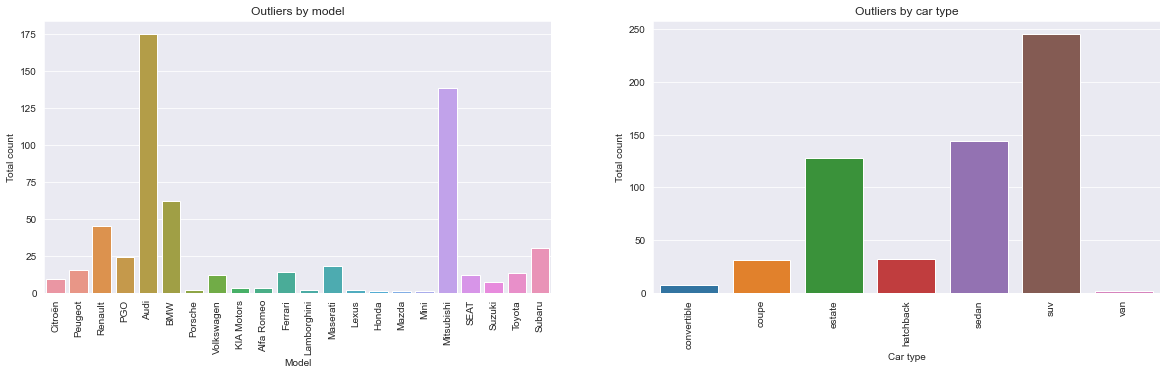

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.countplot(x=outliers_engine_power['model_key'], ax=axes[0])
axes[0].set(xlabel='Model', ylabel='Total count', title='Outliers by model')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=90);

sns.countplot(x=outliers_engine_power['car_type'], ax=axes[1])
axes[1].set(xlabel='Car type', ylabel='Total count', title='Outliers by car type')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=90);


## Categotical features
### Model

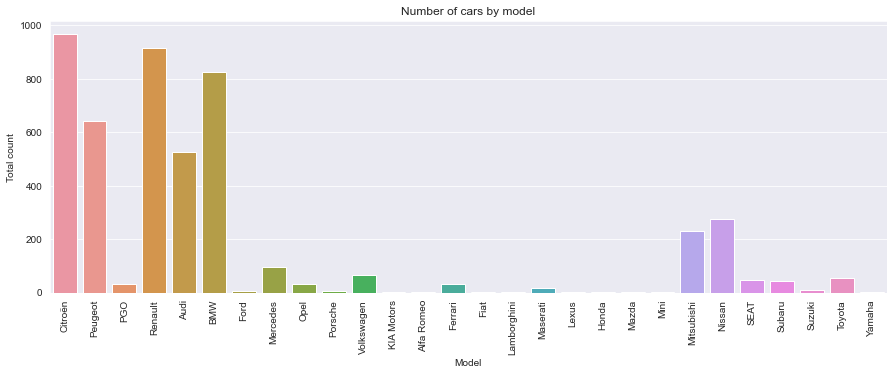

In [69]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=data['model_key'])
ax.set(xlabel='Model', ylabel='Total count', title='Number of cars by model')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90);

### Fuel

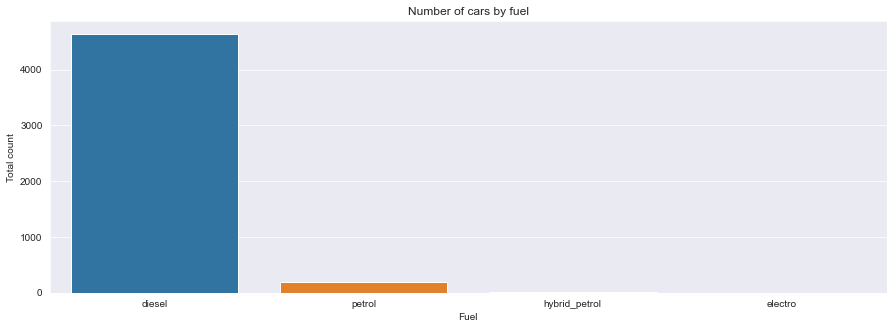

In [72]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=data['fuel'])
ax.set(xlabel='Fuel', ylabel='Total count', title='Number of cars by fuel');

### Paint color

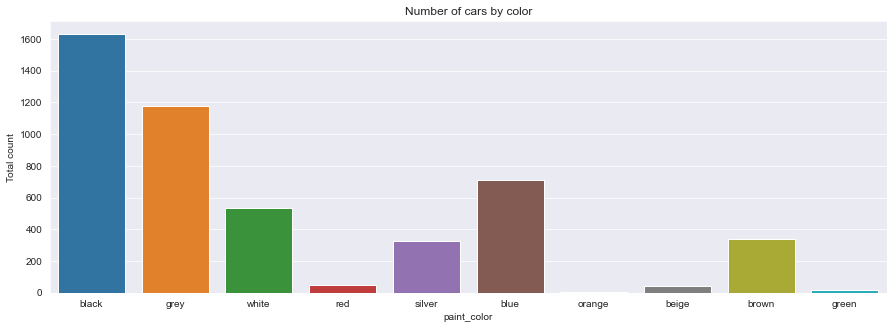

In [73]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=data['paint_color'])
ax.set(xlabel='paint_color', ylabel='Total count', title='Number of cars by color');

### Cart type

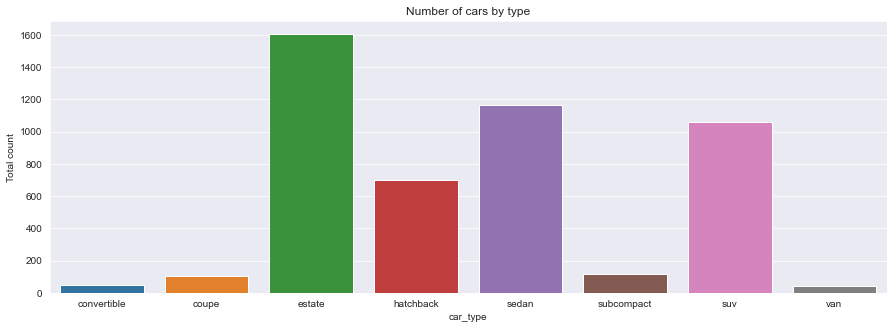

In [74]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=data['car_type'])
ax.set(xlabel='car_type', ylabel='Total count', title='Number of cars by type');

## Binary features

In [75]:
binary_features = ['private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']

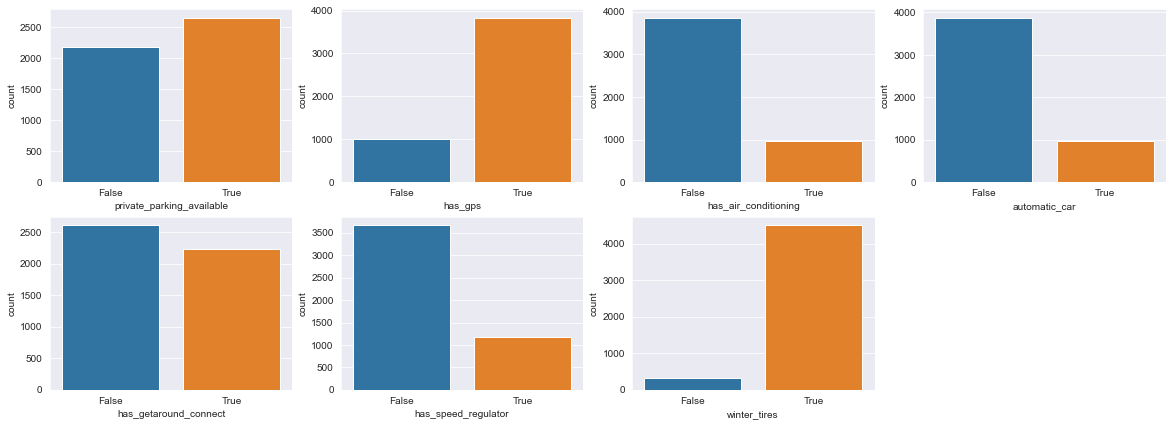

In [87]:
n_rows=2
n_cols=4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7))

for ax in axes.flatten():
    ax.set_axis_off()
    
for column, ax in zip(binary_features, axes.flatten()):
    ax.set_axis_on()
    g = sns.countplot(x=data[column], ax=ax)

## Preprocessing

In [3]:
X = data.loc[:,data.columns != 'rental_price_per_day']
y = data.loc[:,data.columns == 'rental_price_per_day']

In [4]:
# Rare encoding
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=5, variables=['paint_color', 'model_key'],replace_with='Other')
X = rare_encoder.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires
4550,BMW,132485,135,diesel,white,suv,True,True,False,False,False,False,True
1237,Citroën,131121,135,diesel,black,estate,False,True,False,False,True,False,True
3158,Renault,209216,135,diesel,grey,sedan,True,True,False,False,True,False,True
900,Peugeot,148986,100,diesel,black,estate,True,True,False,False,False,False,True
933,Citroën,170500,135,diesel,black,estate,True,True,False,False,False,False,True


In [6]:
categorical_indices = [0,3,4,5,6,7,8,9,10,11,12]
numeric_indices=[1,2]

## Prepare transformers
# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

## Combine the transformers into a single object
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),
        ('num', numeric_transformer, numeric_indices)
        ]
    )

## Apply the transformaters
# Fit and transform on X_train
X_train = featureencoder.fit_transform(X_train)

# Transform on X_test
X_test = featureencoder.transform(X_test)

## Linear regression

In [7]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [8]:
print(f'The score on the train set is {regressor.score(X_train, y_train)}')
print(f'The score on the test set is {regressor.score(X_test, y_test)}')

The score on the train set is 0.7039921450213431
The score on the test set is 0.6789840192373549


## Ridge

In [12]:
ridge_regressor = Ridge()

# Grid of values to be tested
params = {
    'alpha': [0.005, 0.05, 0.5, 1] # 0 corresponds to no regularization
}

gridsearch_ridge = GridSearchCV(ridge_regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch_ridge.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_ridge.best_params_)
print("Best R2 score : ", gridsearch_ridge.best_score_)


Best hyperparameters :  {'alpha': 1}
Best R2 score :  0.6925951387266754


In [13]:
y_train_pred_ridge = gridsearch_ridge.predict(X_train)
y_test_pred_ridge = gridsearch_ridge.predict(X_test)

print("R2 score on training set : ", r2_score(y_train, y_train_pred_ridge))
print("R2 score on test set : ", r2_score(y_test, y_test_pred_ridge))


R2 score on training set :  0.703933685634352
R2 score on test set :  0.6787848646728885


## Random Forest regressor

In [21]:
# Grid of values to be tested
params = {
    'min_samples_split': [1, 2, 3,4,5],
    'min_samples_leaf': [1, 5, 10],
}

gridsearch_rf = GridSearchCV(RandomForestRegressor(), param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch_rf.fit(X_train, y_train)

print("Best hyperparameters : ", gridsearch_rf.best_params_)
print("Best R2 score : ", gridsearch_rf.best_score_)

/Users/marion/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/marion/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/marion/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/marion/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: Dat

Best hyperparameters :  {'min_samples_leaf': 1, 'min_samples_split': 2}
Best R2 score :  0.7391589761759292
